In [308]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
np.random.seed(13)

## Mass Spring Damper System
### 1.
The equation of motion for the mass spring damper system is
$$
m \ddot{r}(t) + c\dot{r}(t) + kr(t) = f(t)
$$
We can write this in state space form, dropping the (t) notation for
brevity, as
$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\dot{x} \\
\ddot{x}\\
\end{bmatrix} =
\begin{bmatrix}
0 & 1 \\
\frac{-k}{m} & \frac{-c}{m} \\
\end{bmatrix}
\begin{bmatrix}
x \\
\dot{x}\\
\end{bmatrix} +
\begin{bmatrix}
0 \\
\frac{1}{m}\\
\end{bmatrix}
u
$$
Where $u = f(t)$

In [309]:
class MassSpringDamper:

    def __init__(self, m, k, c):
        self.m = m
        self.c = c
        self.k = k
        self.f = lambda t: 0
        self.A = np.array([[0, 1],
                           [-self.k/self.m, -self.c/self.m]])
        self.B = np.array([[0],
                           [1/self.m]])
        
    
    def set_force(self, f) -> None:
        self.f = f
    
    def calc_force(self, t):
        return np.array([[self.f(t)]])

    def ode(self, t: float, x:np.ndarray):
        x = x.reshape(2,1)
        x_dot = (self.A @ x) + (self.B @ self.calc_force(t))
        return x_dot.ravel()

Now integrating this with a non-zero initial condition of $\mathbf{x} = [5, 0]^T$,
with a system of $m = 1 kg, k = 1 N/m, c = 0.5 Ns/m $, with no external
force, $f = 0$, we get the following response

In [310]:
# Time
dt = 1e-3
t_start = 0
t_end = 10
t = np.arange(t_start, t_end, dt)
msd = MassSpringDamper(1,0.8,0.5)
x0 = np.array([5,0])
sol = integrate.solve_ivp(
    msd.ode,
    (t_start,t_end),
    x0,
    args=(),
    t_eval=t,
    rtol = 1e-6,
    atol=1e-6,
    method='RK45')

sol_x = sol.y
pos = sol_x[0,:]
vel = sol_x[1,:]

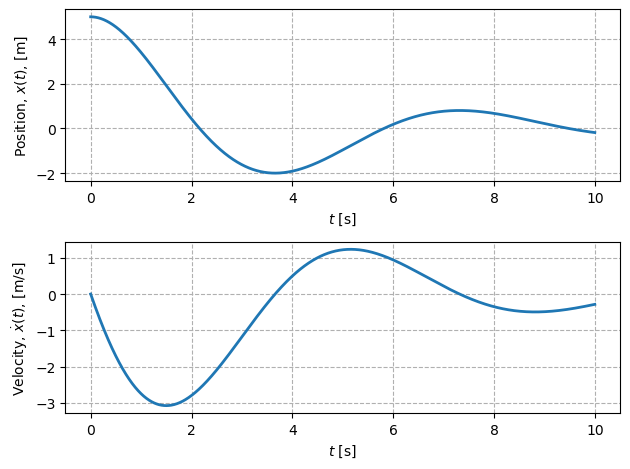

In [311]:
# Plotting
# Plotting parameters
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

fig, ax = plt.subplots(2,1)

ax[0].set_ylabel(r'Position, $x(t)$, [m]')
ax[0].set_xlabel(r'$t$ [s]')
ax[0].plot(t,pos)

ax[1].set_ylabel(r'Velocity, $\dot{x}(t)$, [m/s]')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].plot(t,vel)

fig.tight_layout()
plt.show()

Now with an external force $f = A\sin(\omega t)$ with $A=1N$ and
a frequency of 1 Hz or $\omega = 2\pi \text{rad}/s$

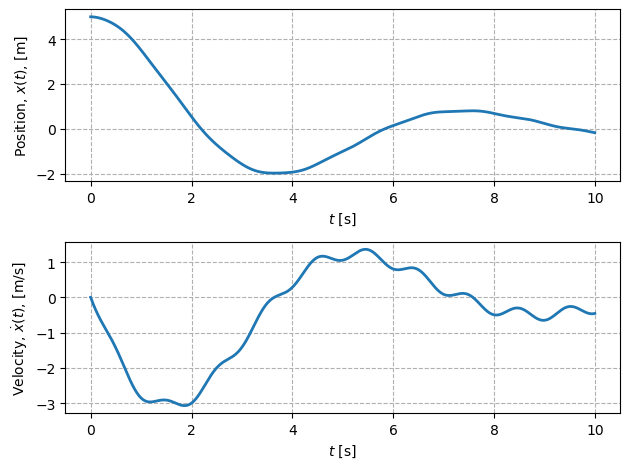

In [312]:
# Forcing function f(t) = A sin(wt)
f = lambda t: 1 * np.sin(2*np.pi*t)
# Change function in mass spring damper
msd.set_force(f)
# Reintegrate
sol = integrate.solve_ivp(
    msd.ode,
    (t_start,t_end),
    x0,
    args=(),
    t_eval=t,
    rtol = 1e-6,
    atol=1e-6,
    method='RK45')

sol_x = sol.y


pos = sol_x[0,:]
vel = sol_x[1,:]
# Plotting
# Plotting parameters
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

fig, ax = plt.subplots(2,1)

ax[0].set_ylabel(r'Position, $x(t)$, [m]')
ax[0].set_xlabel(r'$t$ [s]')
ax[0].plot(t,pos)

ax[1].set_ylabel(r'Velocity, $\dot{x}(t)$, [m/s]')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].plot(t,vel)

fig.tight_layout()
plt.show()

## Generating Sensor Measurements
I'll set the sampling rate of both the accelerometer and
position sensor to 100Hz. Moreover, I set the standard deviation of
the position measurement to 1cm or 0.01m, which seems reasonable
for a position value.
For the accelerometer, it is less obvious what this might be. Using
a datasheet for an average accelerometer, with $ \pm 4 $ g, 10-bit resolution
we have the lowest significant bit LSB representing $0.077\frac{m}{s^2}$.
The datasheet lists an LSB RMS Noise of 0.75, assuming a mean of zero I
set this uncertainty to $0.06\frac{m}{s^2}$.

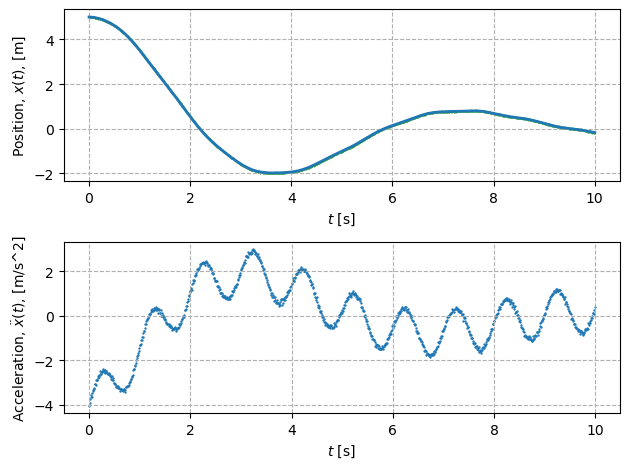

In [313]:
def sensor_measurement(t:float,x:np.ndarray,msd:MassSpringDamper):
    accelerometer = []
    Q = 0.06
    position = []
    R = 0.01
    sensor_time = []
    # Was integrated with dt = 1e-3
    # For 100 Hz then must take every 10th sample
    for i in range(0,len(t),10):
        ddot_r_meas = msd.ode(t[i],x[:,i])[1] + Q*np.random.randn()
        accelerometer.append(ddot_r_meas)
        pos_meas = x[0,i] + R*np.random.randn()
        position.append(pos_meas)
        sensor_time.append(t[i])
    return sensor_time, position, accelerometer

time_data, pos_data, acc_data = sensor_measurement(t,sol_x,msd)


fig, ax = plt.subplots(2,1)

ax[0].set_ylabel(r'Position, $x(t)$, [m]')
ax[0].set_xlabel(r'$t$ [s]')
ax[0].plot(t,pos)
ax[0].scatter(time_data,pos_data, label = "Measured", color='C2',s=0.2)

ax[1].set_ylabel(r'Acceleration, $\ddot{x}(t)$, [m/s^2]')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].scatter(time_data,acc_data,s=0.5)

fig.tight_layout()
plt.show()

## Discretization
Using the fact that $\ddot{r}(t) = u^{\text{acc}}(t) =
a(t) + w(t)$. We can then rewrite our initial state space equation
as
$$
\dot{\mathbf{x}}(t) =
\begin{bmatrix}
0 & 1 \\
0 & 0 \\
\end{bmatrix}\mathbf{x}(t) +
\begin{bmatrix}
0 \\
1 \\
\end{bmatrix}a(t)
+
\begin{bmatrix}
0 \\
1 \\
\end{bmatrix}w(t)
$$
$$
\dot{\mathbf{x}}(t) = \mathbf{Ax}(t) + \mathbf{B}a(t) + \mathbf{L}w(t) \tag{1}
$$
Similarly, our position measurement can be represented as
$$
y(t) = \begin{bmatrix}
1 & 0 \\
\end{bmatrix}\mathbf{x}(t) + v(t)
$$
$$
y(t) = \mathbf{Cx}(t) + v(t) \tag{2}
$$
Taking the Laplace Transform of Equ. 1, we have that
$$
\mathbf{x}(s) = (s -\mathbf{1A})^{-1}\mathbf{x}_0 + (s -\mathbf{1A})^{-1}\mathbf{B}a(s) + (s -\mathbf{1A})^{-1}\mathbf{L}w(s) \tag{3}
$$
The solution to this is then
$$
x(t) = e^{\mathbf{A}(t-t_0)}\mathbf{x}(t_0) +
\int_{t_0}^{t}e^{\mathbf{A}(t-\tau)}\mathbf{B}a(\tau)d\tau +
\int_{t_0}^{t}e^{\mathbf{A}(t-\tau)}\mathbf{L}w(\tau)d\tau
$$
Then through a zero-order hold, assuming the input is constant over
a time interval, $ T = t_{k}- t_{k-1} $, we have that
$$
\mathbf{x}_k = \underbrace{e^{\mathbf{A}T}}_{\mathbf{A_{k-1}}}\mathbf{x}_{k-1} +
\underbrace{\int_{0}^{T}e^{\mathbf{A}\tau}d\tau \mathbf{B}}_{\mathbf{B}_{k-1}}a_{k-1}
+ \underbrace{\int_{0}^{T}e^{\mathbf{A}\tau}d\tau \mathbf{L}w_{k-1}}_{\mathbf{w}_{k-1}} \tag{4}
$$
where $\mathbf{w}_{k-1}$ is defined as
$$
\mathbf{w}_{k-1} \sim \mathcal{N}(\mathbf{0},\mathbf{Q}_{k-1}) \tag{5}
$$
Explicitly calculating $\mathbf{A}_{k-1}$
$$
\mathbf{A}_{k-1} = e^{\mathbf{A}\tau} = \mathbf{1} + \mathbf{A}T + \frac{(\mathbf{A}T)^2}{2!} + \ldots
$$
For the $\mathbf{A}$ defined in Equ. 1, we have that $\mathbf{A}^2 = 0$ thus
$$
\mathbf{A}_{k-1} =
\begin{bmatrix}
1 & T \\
0 & 1\\
\end{bmatrix}
$$
Similarly, for $\mathbf{B}_{k-1}$
$$
\begin{align*}
\mathbf{B}_{k-1} &= \int_{0}^{T}e^{\mathbf{A}\tau}d\tau \mathbf{B} \\
&=  (\int_{0}^{T}\begin{bmatrix}
1 & \tau \\
0 & 1\\
\end{bmatrix})\mathbf{B} \\
&= \begin{bmatrix}
T & \frac{1}{2}T^2 \\
0 & T\\
\end{bmatrix}
\begin{bmatrix}
0 \\
1 \\
\end{bmatrix} \\
&=
\begin{bmatrix}
\frac{1}{2}T^2 \\
T \\
\end{bmatrix}
\end{align*}
$$
Similarly,
$$
\begin{align*}
\mathbf{w}_{k-1} &= \int_{0}^{T}e^{\mathbf{A}\tau}d\tau \mathbf{L}w_{k-1} \\
&= \begin{bmatrix}
\frac{1}{2}T^2 \\
T \\
\end{bmatrix}w_{k-1}
\end{align*}
$$
Using Van Loan's Method as detailed in [2,3], we can write
the process noise $\mathbf{Q}_{k-1}$ as
$$
\begin{align*}
\mathbf{Q}_{k-1} &= \int_{0}^{T}e^{\mathbf{A}\tau}\mathbf{Q}e^{\mathbf{A^{\top}}\tau}d\tau \\
&\approx \mathbf{B}_{k-1}\mathbf{B}_{k-1}^{\top}\sigma_a^2 \\
&=
\begin{bmatrix}
\frac{1}{4}T^4 & \frac{1}{2}T^3 \\
\frac{1}{2}T^3 & T^2 \\
\end{bmatrix}\sigma_a^2
\end{align*}
$$
The discretized process model can be written as
$$
\mathbf{x}_k =
\begin{bmatrix}
1 & T \\
0 & 1\\
\end{bmatrix}\mathbf{x}_{k-1} +
\begin{bmatrix}
\frac{1}{2}T^2 \\
T \\
\end{bmatrix}a_{k-1} +
\begin{bmatrix}
\frac{1}{2}T^2 \\
T \\
\end{bmatrix}w_{k-1}
$$
For measurement model, the discretized form is much easier to write with
$$
y_k = \begin{bmatrix} 1 & 0 \end{bmatrix}\mathbf{x}_k + v_k
$$

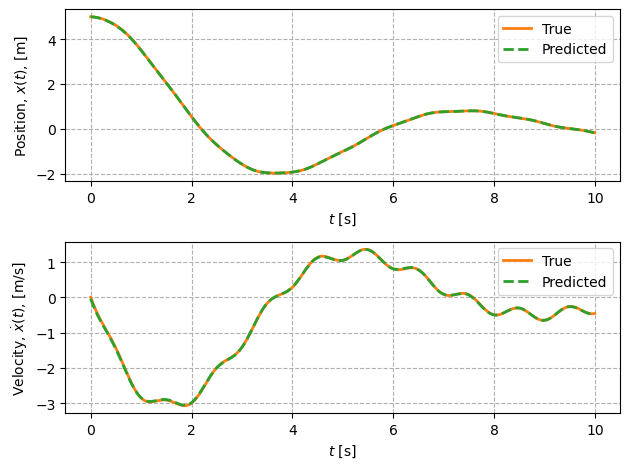

(1000, 2)


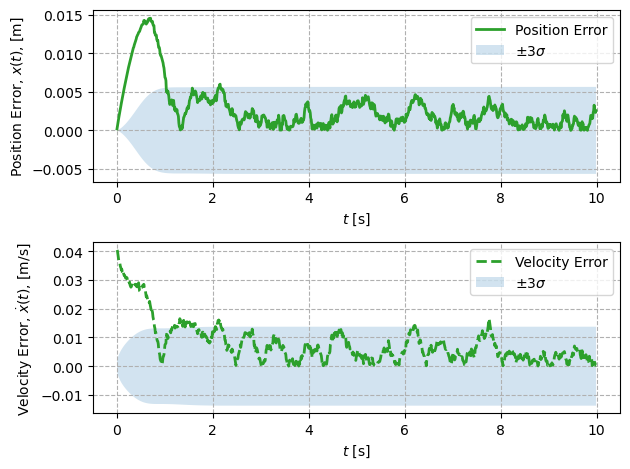

In [314]:
class KalmanFilter():
    def __init__(self,A:np.ndarray,B:np.ndarray,C:np.ndarray,
                 Q:np.ndarray,R:np.ndarray,x0:np.ndarray, P0:np.ndarray):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.P_k = P0
        self.K_k = None
        # State
        self.x = x0
        # Measurements
        self.u_acc = None
        self.y_k = None

    def get_measurement(self, u_acc, y_k):
        self.u_acc = np.array([[u_acc]])
        self.y_k = np.array([[y_k]])

    def predict(self) -> np.ndarray:
        # Insert Prediction step
        self.x = self.A @ self.x + self.B @ self.u_acc
        self.P_k = self.A @ self.P_k @ self.A.T + self.Q
        return self.x
    
    def correct(self) -> None:
        # Insert Correction Step
        tmp = (self.C @ self.P_k @ self.C.T) + self.R
        self.K_k = self.P_k @ self.C.T @ np.linalg.inv(tmp)
        self.x = self.x + self.K_k @ (self.y_k - (self.C @ self.x))
        self.P_k = (np.eye(self.K_k.shape[0],self.C.shape[1]) - 
                    (self.K_k @ self.C)) @ self.P_k
        return

sample_rate = 100
dt = 1 / sample_rate
sigma_a = 0.06
sigma_r = 0.01
A = np.array([[1, dt],
              [0, 1]])
B = np.array([[0.5 * dt**2],
              [dt]])
C = np.array([[1, 0]])

Q = (B @ B.T) * sigma_a**2

R = np.array([[sigma_r**2]])

# Set to initial conditions
# Assuming these are known, with certainty
x0 = x0.reshape((2,1))
P0 = np.zeros((2,2))

kalman = KalmanFilter(A,B,C,Q,R,x0,P0)

pos_est = []
vel_est = []
sigma_list = []

for i in range(len(pos_data)):
    y = pos_data[i]
    u = acc_data[i]
    kalman.get_measurement(u,y)
    x_est = kalman.predict()
    pos_est.append(x_est[0])
    vel_est.append(x_est[1])
    sigma = np.sqrt(np.diag(kalman.P_k))
    sigma_list.append(sigma)
    kalman.correct()

# Kalman Plots
fig, ax = plt.subplots(2,1)
ax[0].set_ylabel(r'Position, $x(t)$, [m]')
ax[0].set_xlabel(r'$t$ [s]')
ax[0].plot(t,pos,label="True",color='C1')
ax[0].plot(time_data,pos_est,label="Predicted",color="C2",linestyle="--")
ax[0].legend()

ax[1].set_ylabel(r'Velocity, $\dot{x}(t)$, [m/s]')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].plot(t,vel,label="True",color='C1')
ax[1].plot(time_data,vel_est,label="Predicted",color="C2",linestyle="--")
ax[1].legend()

fig.tight_layout()
plt.show()

# Error Plots
pos_error = []
vel_error = []
for i in range(0,len(pos),10):
    pos_error.append(abs(pos_est[i//10] - pos[i]))
    vel_error.append(abs(vel_est[i//10] - vel[i]))

fig, ax = plt.subplots(2,1)
sigma_list = np.array(sigma_list)
print(sigma_list.shape)
three_sigma_pos = sigma_list[:,0]*3
three_sigma_vel = sigma_list[:,1]*3

ax[0].set_ylabel(r'Position Error, $x(t)$, [m]')
ax[0].set_xlabel(r'$t$ [s]')
ax[0].plot(time_data,pos_error,label="Position Error",color="C2",linestyle="-")
ax[0].fill_between(time_data,three_sigma_pos,-1*three_sigma_pos,alpha=0.2,label='$\pm 3\sigma$') 
ax[0].legend()

ax[1].set_ylabel(r'Velocity Error, $\dot{x}(t)$, [m/s]')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].plot(time_data,vel_error,label="Velocity Error",color="C2",linestyle="--")
ax[1].fill_between(time_data,three_sigma_vel,-1*three_sigma_vel,alpha=0.2,label='$\pm 3\sigma$') 
ax[1].legend()

fig.tight_layout()
plt.show()

Let's now limit the frequency of the position measurement to 1/10th
the frequency of the accelerometer. We do this by only taking every 10th
measurement of the position measurement, using the modulo operator (%). Everytime
we receive a position measurement, we can also now correct our kalman prediction
at these times.

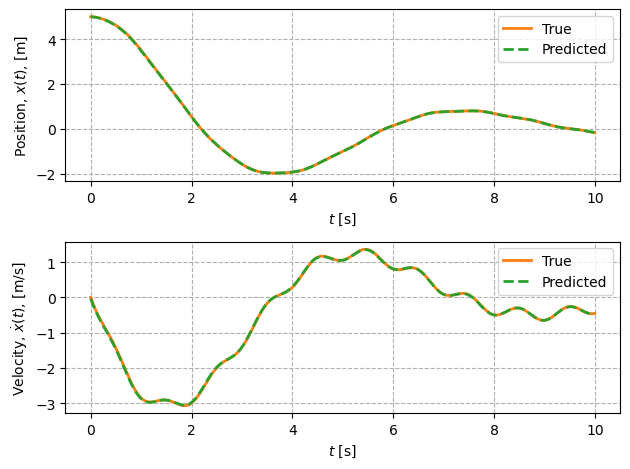

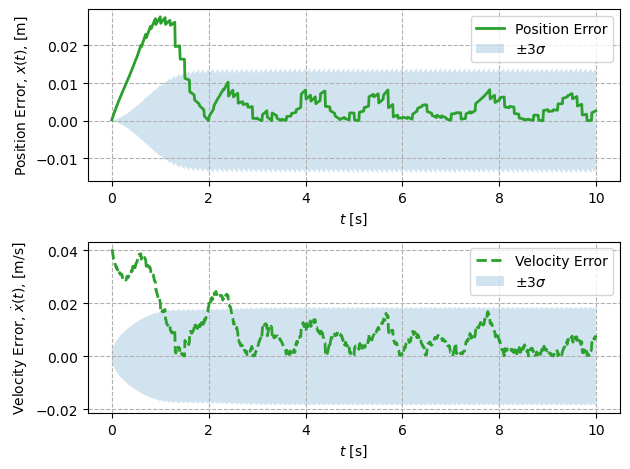

In [315]:
kalman = KalmanFilter(A,B,C,Q,R,x0,P0)

pos_est = []
vel_est = []
sigma_list = []

for i in range(len(pos_data)):
    u = acc_data[i]
    # Only take every 10th measurement
    if i % 10 == 0:
        y = pos_data[i]
        # Used to update the 
        can_correct = True

    kalman.get_measurement(u,y)
    x_est = kalman.predict()
    sigma = np.sqrt(np.diag(kalman.P_k))
    sigma_list.append(sigma)
    pos_est.append(x_est[0])
    vel_est.append(x_est[1])
    if can_correct:
        kalman.correct()
    can_correct = False

# Kalman Plots
fig, ax = plt.subplots(2,1)
ax[0].set_ylabel(r'Position, $x(t)$, [m]')
ax[0].set_xlabel(r'$t$ [s]')
ax[0].plot(t,pos,label="True",color='C1')
ax[0].plot(time_data,pos_est,label="Predicted",color="C2",linestyle="--")
ax[0].legend()

ax[1].set_ylabel(r'Velocity, $\dot{x}(t)$, [m/s]')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].plot(t,vel,label="True",color='C1')
ax[1].plot(time_data,vel_est,label="Predicted",color="C2",linestyle="--")
ax[1].legend()

fig.tight_layout()
plt.show()

# Error Plots
pos_error = []
vel_error = []
for i in range(0,len(pos),10):
    pos_error.append(abs(pos_est[i//10] - pos[i]))
    vel_error.append(abs(vel_est[i//10] - vel[i]))

fig, ax = plt.subplots(2,1)
sigma_list = np.array(sigma_list)
three_sigma_pos = sigma_list[:,0]*3
three_sigma_vel = sigma_list[:,1]*3

ax[0].set_ylabel(r'Position Error, $x(t)$, [m]')
ax[0].set_xlabel(r'$t$ [s]')
ax[0].plot(time_data,pos_error,label="Position Error",color="C2",linestyle="-")
ax[0].fill_between(time_data,three_sigma_pos,-1*three_sigma_pos,alpha=0.2,label='$\pm 3\sigma$') 
ax[0].legend()

ax[1].set_ylabel(r'Velocity Error, $\dot{x}(t)$, [m/s]')
ax[1].set_xlabel(r'$t$ [s]')
ax[1].plot(time_data,vel_error,label="Velocity Error",color="C2",linestyle="--")
ax[1].fill_between(time_data,three_sigma_vel,-1*three_sigma_vel,alpha=0.2,label='$\pm 3\sigma$') 
ax[1].legend()

fig.tight_layout()
plt.show()

## Bibliography
[1] https://www.analog.com/media/en/technical-documentation/data-sheets/adxl345.pdf \
[2] https://en.wikipedia.org/wiki/Discretization \
[3]  Charles Van Loan: Computing integrals involving the matrix exponential, IEEE Transactions on Automatic Control. 23 (3): 395–404, 1978